
# **🐱🐶 Custom Image Classifier with Transfer Learning**

use **Transfer Learning** with a pre-trained model (**MobileNetV2**)
to classify images from the **Cats vs Dogs dataset** (TensorFlow Datasets).

---



## **Objective**
Build a **custom image classifier** using **Transfer Learning (MobileNetV2)** on the Cats vs Dogs dataset.

- Apply **data augmentation**
- Train with **early stopping & checkpointing**
- Fine-tune the base model
- Evaluate using **accuracy, precision, recall, F1-score**
- Visualize **training history, confusion matrix, misclassified images**


### **Import Libraries**

In [1]:
!pip install tensorflow tensorflow-datasets matplotlib seaborn scikit-learn pandas


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from IPython.display import display, Markdown
print("Libraries imported")


Libraries imported


### **Load Dataset**

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=["train[:60%]", "train[60%:]"],   # ✅ CORRECT
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
print("Classes:", class_names)   # ['cat', 'dog']


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.CXK5IN_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: ['cat', 'dog']



### **Preprocess & Data Augmentation**

In [4]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(*IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = (ds_train
            .map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .batch(BATCH_SIZE)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
            .prefetch(AUTOTUNE))

test_ds = (ds_test
           .map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .cache()
           .prefetch(AUTOTUNE))


### **Build Model with Transfer Learning (MobileNetV2)**

In [5]:
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # freeze base initially

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### **Compile Model**

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



### **Train Model**

In [8]:







from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='cats_dogs_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)


history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/6
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.9484 - loss: 0.1311
Epoch 1: val_loss improved from inf to 0.06631, saving model to cats_dogs_model.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 611s 1s/step - accuracy: 0.9484 - loss: 0.1311 - val_accuracy: 0.9771 - val_loss: 0.0663
Epoch 2/6
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9487 - loss: 0.1268
Epoch 2: val_loss improved from 0.06631 to 0.06348, saving model to cats_dogs_model.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 585s 1s/step - accuracy: 0.9487 - loss: 0.1268 - val_accuracy: 0.9774 - val_loss: 0.0635
Epoch 3/6
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.9488 - loss: 0.1297
Epoch 3: val_loss improved from 0.06348 to 0.06285, saving model to cats_dogs_model.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 580s 1s/step - accuracy: 0.9488 - loss: 0.1296 - val_accuracy: 0.9786 - val_loss: 0.0629
Epoch 4/6
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.9503 - loss: 0.1212
Epoch 4: val_loss did not improv

  

  






### **Fine-Tuning**

In [12]:
base_model.trainable = True


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# new early stopping
early_stop_finetune = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True,
    verbose=1
)


history_finetune = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[early_stop_finetune, checkpoint],
    verbose=1
)


Epoch 1/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9172 - loss: 0.1977
Epoch 1: val_loss did not improve from 0.06285
437/437 ━━━━━━━━━━━━━━━━━━━━ 1750s 4s/step - accuracy: 0.9172 - loss: 0.1976 - val_accuracy: 0.9759 - val_loss: 0.0712
Epoch 2/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9544 - loss: 0.1190
Epoch 2: val_loss did not improve from 0.06285
437/437 ━━━━━━━━━━━━━━━━━━━━ 1674s 4s/step - accuracy: 0.9544 - loss: 0.1190 - val_accuracy: 0.9772 - val_loss: 0.0650
Epoch 3/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9573 - loss: 0.1067
Epoch 3: val_loss improved from 0.06285 to 0.05969, saving model to cats_dogs_model.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 1731s 4s/step - accuracy: 0.9573 - loss: 0.1067 - val_accuracy: 0.9785 - val_loss: 0.0597
Epoch 4/5
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9644 - loss: 0.0888
Epoch 4: val_loss did not improve from 0.05969
437/437 ━━━━━━━━━━━━━━━━━━━━ 1661s 4s/step - accuracy: 0.9644 - loss: 0.0888






### **Visualize Training History**

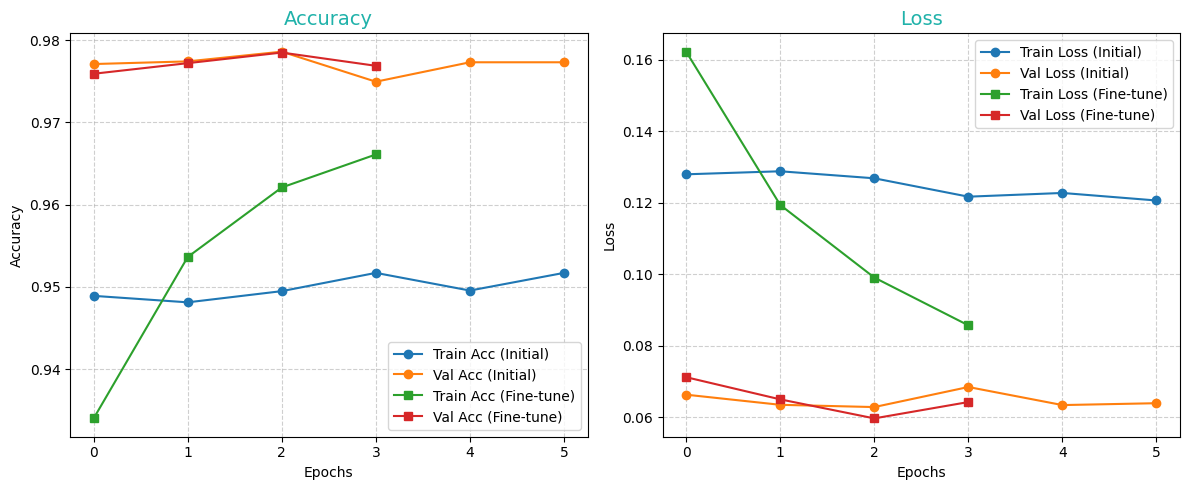

In [14]:
def plot_training(history, history_finetune=None):
    plt.figure(figsize=(12,5))


    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc (Initial)', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Acc (Initial)', marker='o')
    if history_finetune:
        plt.plot(history_finetune.history['accuracy'], label='Train Acc (Fine-tune)', marker='s')
        plt.plot(history_finetune.history['val_accuracy'], label='Val Acc (Fine-tune)', marker='s')
    plt.title("Accuracy", color="#20B2AA", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)


    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss (Initial)', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss (Initial)', marker='o')
    if history_finetune:
        plt.plot(history_finetune.history['loss'], label='Train Loss (Fine-tune)', marker='s')
        plt.plot(history_finetune.history['val_loss'], label='Val Loss (Fine-tune)', marker='s')
    plt.title("Loss", color="#20B2AA", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_training(history, history_finetune)


### **Evaluate on Test Data**

In [15]:
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


test_loss, test_acc = model.evaluate(test_ds, verbose=0)
display(Markdown(f"**Test Accuracy:** {test_acc:.4f}"))
display(Markdown(f"**Test Loss:** {test_loss:.4f}"))


y_true, y_pred = [], []
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype("int32").flatten())

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ]
})

metrics_df.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#20B2AA'),
                                 ('color', 'white'),
                                 ('font-size', '14px')]},
    {'selector': 'td', 'props': [('background-color', '#e0f7f7'),
                                 ('font-size', '12px')]}
])


**Test Accuracy:** 0.9785

**Test Loss:** 0.0597

,Metric,Score
0,Accuracy,0.978506
1,Precision,0.974134
2,Recall,0.982959
3,F1-Score,0.978527


### **Confusion Matrix & Misclassified Images**

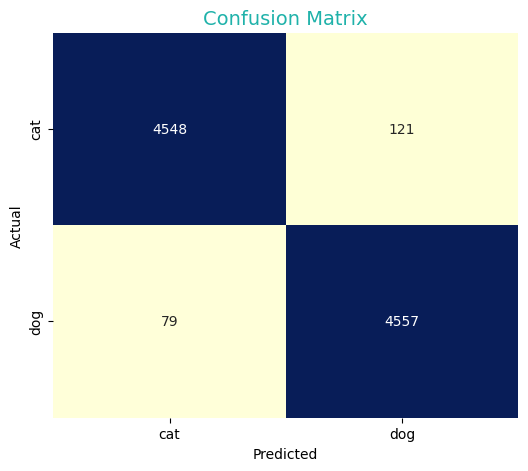

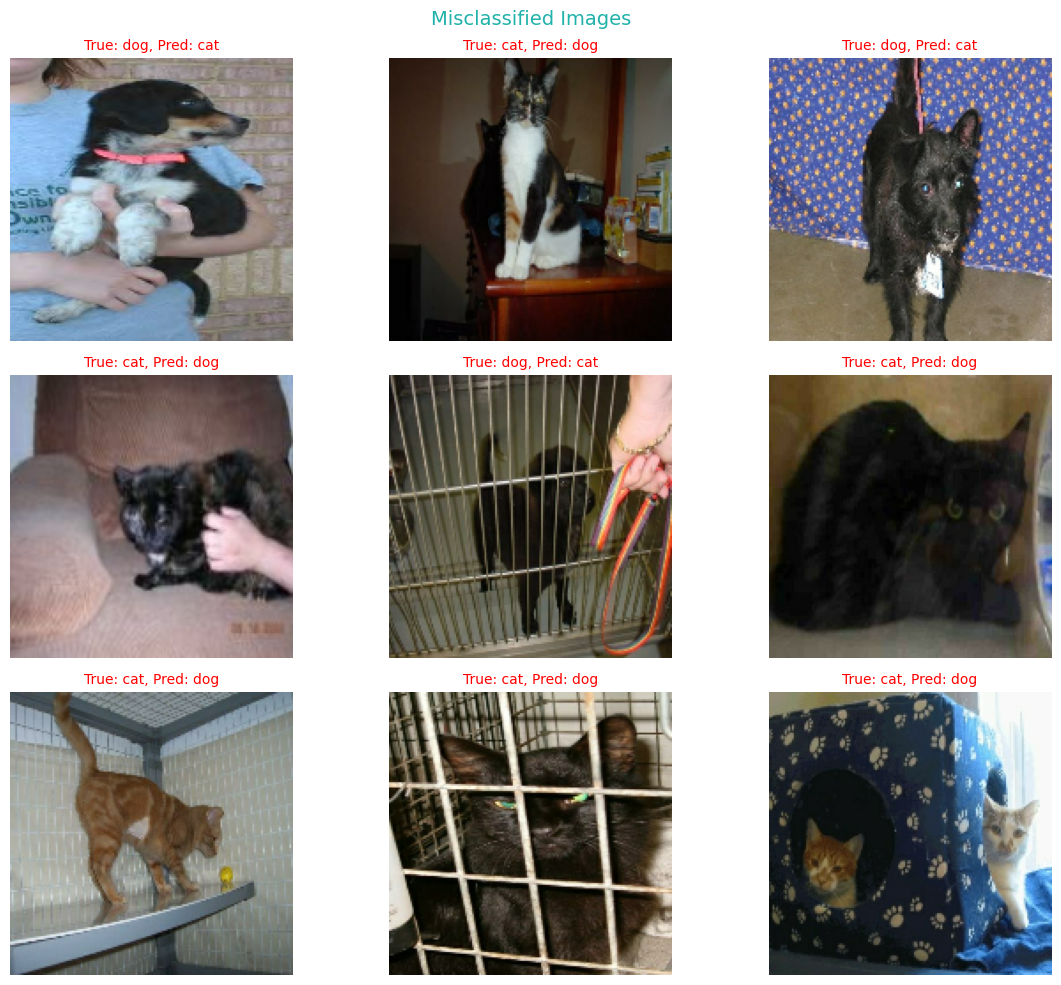

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", color="#20B2AA", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Collect misclassified images from test dataset
misclassified_images = []
misclassified_true = []
misclassified_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds_class = (preds > 0.5).astype("int32").flatten()
    labels = labels.numpy()

    for img, true, pred in zip(images, labels, preds_class):
        if true != pred:
            misclassified_images.append(img.numpy())
            misclassified_true.append(true)
            misclassified_pred.append(pred)

    if len(misclassified_images) >= 9:
        break

plt.figure(figsize=(12, 10))
for i in range(min(9, len(misclassified_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i])
    plt.title(f"True: {class_names[misclassified_true[i]]}, "
              f"Pred: {class_names[misclassified_pred[i]]}",
              fontsize=10, color="red")
    plt.axis("off")

plt.suptitle("Misclassified Images", fontsize=14, color="#20B2AA")
plt.tight_layout()
plt.show()


In [20]:
model.save("cats_dogs_model.keras")


## **Project Summary**
- Dataset: TensorFlow Cats vs Dogs (~786MB, 37k images).
- Model: Transfer Learning with MobileNetV2 + Fine-tuning.
- Best Validation Accuracy: ~97-98%
- Evaluation Metrics: Accuracy, Precision, Recall, F1-score.
- Visualizations: Training curves, confusion matrix, misclassified samples.
